# Comparison of Models

This script will take the outputs of each model and compare them using the different metrics. It will generate a general results table

In [1]:
import numpy as np
import matlab.engine
import pandas as pd
import scipy.io as sio
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functions.functions import load_data_forGridSearch, load_object
# from functions.functions_metrics import evaluate_generic_metrics

In [2]:
def evaluate_generic_metrics(labels, predictions):
    
    # label_norm = np.sqrt(np.sum(labels**2, axis=1))
    # prediction_norm = np.sqrt(np.sum(predictions**2, axis=1))
    label_norm = [np.linalg.norm(y) for y in labels]
    prediction_norm = [np.linalg.norm(y) for y in predictions]
    
    # R^2
    r2_c = r2_score(y_true=labels, y_pred=predictions, multioutput='raw_values')
    r2 = r2_score(y_true=labels, y_pred=predictions)
    r2_norm = r2_score(y_true=label_norm, y_pred=prediction_norm)

    # Root mean squared error
    rmse_c = np.sqrt(mean_squared_error(y_true=labels, y_pred=predictions, multioutput='raw_values'))
    rmse = np.sqrt(mean_squared_error(y_true=labels, y_pred=predictions))
    rmse_norm = np.sqrt(mean_squared_error(y_true=label_norm, y_pred=prediction_norm))
    
    # mean absolute error
    mae = mean_absolute_error(y_true=labels, y_pred=predictions)
    mae_norm = mean_absolute_error(y_true=label_norm, y_pred=prediction_norm)
    
    nmae = mae / (np.max(labels) - np.min(labels))
    nrmse = rmse / (np.max(labels) - np.min(labels))

    return {"R2_x": round(r2_c[0], 3),
            "R2_y": round(r2_c[1], 3),
            "R2_z": round(r2_c[2], 3),
            "R2": round(r2, 3),
            "R2_norm": round(r2_norm, 3),
            "RMSE_x_mT": round(rmse_c[0]*1000, 2),
            "RMSE_y_mT": round(rmse_c[1]*1000, 2),
            "RMSE_z_mT": round(rmse_c[2]*1000, 2),
            "MAE_mT": round(mae*1000, 2),
            "MAE_norm_mT": round(mae_norm*1000, 2),
            "N-MAE" : round(nmae*100,2),
            "RMSE_mT": round(rmse*1000, 2),
            "N-RMSE":round(nrmse*100,2),
            "RMSE_norm_mT": round(rmse_norm*1000,2)}

In [3]:
# load testing data
X_test, y_test = load_data_forGridSearch("../Data", "test")

## Baseline model (recalibrated)

In [4]:
# load matlab predictions
recalibrated_y_pred = sio.loadmat('./baseline_model/magnetic_model/CalibrateSystem_CardioMag_retrained_w_SensorGrid/recalibrated_y_pred.mat')['fieldStrength']
recalibrated_y_pred = recalibrated_y_pred[:,0:3]
assert recalibrated_y_pred.shape == y_test.shape, "Predictions for testing set do not have the same shape as the labels"

In [5]:
baseline_results_recalibrated = evaluate_generic_metrics(y_test, recalibrated_y_pred)
baseline_results_recalibrated['model'] = 'MPEM'

## Random forest model

In [6]:
rf_y_pred = np.load("../Models/RF/GridSearch_RF_predictions.npy")

In [7]:
rf_results = evaluate_generic_metrics(y_test, rf_y_pred)
rf_results['model'] = 'RF'

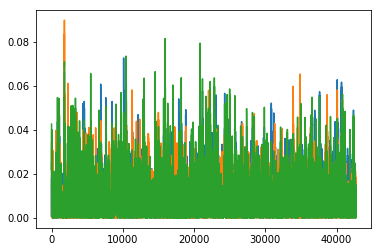

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.abs(y_test - rf_y_pred))

## ANN model

In [9]:
mlp_y_pred = np.load('../Models/ANN/predictions_ANN.npy')
mlp_results = evaluate_generic_metrics(y_test, mlp_y_pred)
mlp_results['model'] = 'ANN'

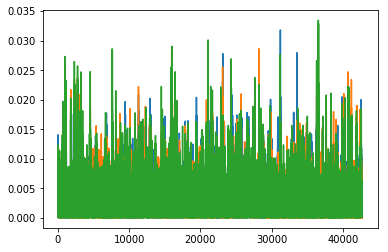

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.abs(y_test - mlp_y_pred))

## S-MPEM

In [11]:
s_mpem_y_pred = np.load('../Models/S-MPEM/predictions_S-MPEM.npy')
s_mpem_results = evaluate_generic_metrics(y_test, s_mpem_y_pred)
s_mpem_results['model'] = 'S-MPEM'

## Deep Fluids

In [14]:
cnn_y_pred = np.load('../Models/CNN/predictions.npy')
cnn_y_test = np.load('../Models/CNN/observations.npy')
cnn_results = evaluate_generic_metrics(cnn_y_test, cnn_y_pred)
cnn_results['model'] = 'CNN'

In [15]:
cnn_df_y_pred = np.load('../Models/CNN-DF/predictions.npy')
cnn_df_y_test = np.load('../Models/CNN-DF/observations.npy')
cnn_df_results = evaluate_generic_metrics(cnn_df_y_test, cnn_df_y_pred)
cnn_df_results['model'] = 'CNN-DF'

## Overall comparison

In [16]:
results = pd.DataFrame.from_dict([baseline_results_recalibrated, rf_results,s_mpem_results, mlp_results, cnn_df_results, cnn_results])

In [17]:
results[['model','MAE_mT', 'MAE_norm_mT', 'N-MAE', 'RMSE_mT', 'N-RMSE', 'R2']]

,model,MAE_mT,MAE_norm_mT,N-MAE,RMSE_mT,N-RMSE,R2
0,MPEM,8.98,15.45,2.75,14.90,4.57,0.809
1,RF,8.66,10.62,2.66,11.81,3.62,0.879
2,S-MPEM,2.84,3.35,0.87,4.44,1.36,0.983
3,ANN,2.76,2.91,0.85,3.88,1.19,0.987
4,CNN-DF,0.64,0.68,0.19,0.94,0.28,0.999
5,CNN,0.58,0.61,0.17,0.91,0.27,0.999


In [18]:
results[['model', 'R2_x','R2_y', 'R2_z', 'R2', 'RMSE_x_mT', 'RMSE_y_mT', 'RMSE_z_mT', 'RMSE_mT']]

,model,R2_x,R2_y,R2_z,R2,RMSE_x_mT,RMSE_y_mT,RMSE_z_mT,RMSE_mT
0,MPEM,0.860,0.808,0.760,0.809,14.34,15.81,14.51,14.90
1,RF,0.904,0.899,0.833,0.879,11.88,11.45,12.10,11.81
2,S-MPEM,0.983,0.989,0.976,0.983,4.96,3.70,4.57,4.44
3,ANN,0.990,0.989,0.981,0.987,3.77,3.76,4.10,3.88
4,CNN-DF,0.999,0.999,0.999,0.999,1.07,0.89,0.84,0.94
5,CNN,0.999,0.999,0.999,0.999,1.04,0.82,0.86,0.91
